In [108]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import keras
from ultralytics import YOLO
import numpy as np
import os

In [109]:
root = "."

confThreshold = 0.5
nmsThreshold = 0.4
netsize = 416

segwidth, segheight = 300, 100
segdims = [int(0.04 * segwidth), int(0.11 * segwidth), int(0.65 * segheight), int(0.95 * segheight)]
specialsegdims = [segdims[0], segdims[1], int(0.38 * segheight), int(0.48 * segheight)]

In [110]:
detector = YOLO(f"{root}/model.pt")

In [111]:
charnet = keras.models.load_model(f"{root}/charnet.keras")

In [112]:
def show(img, title="image", **kwargs):
    plt.imshow(img, **kwargs)
    plt.title(title)
    plt.show()

In [113]:
def input(path):
  op = cv2.imread(path)
  image = cv2.cvtColor(op, cv2.COLOR_RGB2BGR)
  plt.imshow(image)
  plt.title(os.path.basename(path))
  plt.show()
  return image

In [114]:
def predict(img):
    detections = detector(img)[0]
    predictions = []

    for det in detections.boxes.data.tolist():
        x1, y1, x2, y2, _, class_id = det
        if int(class_id) == 0:
            predictions.append([int(x1), int(y1), int(x2), int(y2)])

    return predictions

def crop_plates(img):
  plates = []

  predictions = predict(img)
  for box in predictions:
      x1 = box[0]
      y1 = box[1]
      x2 = box[2]
      y2 = box[3]

      plates.append(img[y1:y2, x1:x2])

  return plates

In [115]:
def projective_transform(img, x1, y1, x2, y2, x3, y3, x4, y4):
    plate_corners = np.array([[x1, y1], [x2, y2], [x4, y4], [x3, y3]], dtype=np.float32)
    plate_width = int(max(np.linalg.norm(plate_corners[0] - plate_corners[1]), np.linalg.norm(plate_corners[2] - plate_corners[3])))
    plate_height = int(max(np.linalg.norm(plate_corners[0] - plate_corners[3]), np.linalg.norm(plate_corners[1] - plate_corners[2])))
    target_corners = np.array([[0, 0], [plate_width - 1, 0], [plate_width - 1, plate_height - 1], [0, plate_height - 1]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(plate_corners, target_corners)
    plate_transformed = cv2.warpPerspective(img, M, (plate_width, plate_height))

    return plate_transformed

In [116]:
def getpoints(image):
    tl = None
    tr = None
    bl = None
    br = None

    height, width = image.shape

    for i in range(0, width, 1):
        for j in range(0, min(i + 1, height), 1):
            if tl is None:
                x = i - j
                y = j

                if image[y][x] != 0:
                    tl = (x, y)

            if tr is None:
                x = j - i + width - 1
                y = j

                if image[y][x] != 0:
                    tr = (x, y)

            if bl is None:
                x = i - j
                y = height - j - 1

                if image[y][x] != 0:
                    bl = (x, y)

            if br is None:
                x = j - i + width - 1
                y = height - j - 1

                if image[y][x] != 0:
                    br = (x, y)
            
            if tl is not None and tr is not None and bl is not None and br is not None:
                break
    
    return [tl, tr, bl, br]

In [117]:
def rotate_plate(plate):
  resized = cv2.resize(plate, (333, 75))
  show(resized, "resized")

  image = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
  meanbrightness = image.mean(axis=0).mean(axis=0)
  if meanbrightness < 48:
    image = (image * (meanbrightness / 32)).astype(np.int8)
    print(image)

  height, width = image.shape

  plt.imshow(image, cmap="gray")
  plt.title("rotate resized input")
  plt.show()

  blurred = cv2.GaussianBlur(image, (3, 3), 1)
  # blurred = cv2.bilateralFilter(image, 9, 25, 25)
  plt.imshow(blurred, cmap="gray")
  plt.title("blurred")
  plt.show()

  edges = cv2.Canny(blurred, 255, 255 / 3)
  edges = cv2.dilate(edges, (3, 3))

  plt.imshow(edges, cmap="gray")
  plt.title("edges")
  plt.show()

  _x = width - 1
  for y in range(2, height - 2):
    edges[y][0] = 255
    edges[y][_x] = 255

  # Trenutno ne gledamo hijerarhiju kontura (korisno za filtriranje bitnih kontura).
  contours, _ = cv2.findContours(edges, 
      cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

  # Sortiranje kontura po površini, tako da je prva kontura najveća
  contours = sorted(contours, key=cv2.contourArea, reverse=True)
  contour = contours[0]

  # Pravimo binarnu sliku koja sadrži sve tačke svih kontura
  contoursimg = np.zeros([height, width, 1], dtype="uint8")

  for [[x, y]] in contour:
      contoursimg[y, x] = 255

  # Vizuelizacija kontura
  plt.imshow(contoursimg, cmap="gray")
  plt.title("contoursimg")
  plt.show()

  # Popunjavanje konture radi mnogo lakšeg filtriranja nebitnih kontura
  filledimg = cv2.fillPoly(contoursimg.copy(), pts=[contour], color=(255, 255, 255))

  # Vizuelizacija popunjene konture
  plt.imshow(filledimg, cmap="gray")
  plt.title("filledimg")
  plt.show()

  # Definisanje "jačine" erozije i dilatacije za sledeći korak
  kernel = np.ones([10, 10])

  # Prvo vršimo veoma jaku eroziju da se otarasimo nebitnih kontura
  processedimg = cv2.erode(filledimg.copy(), kernel)
  # A zatim dilataciju iste jačine kako bismo dobili samo popunjenu konturu tablice
  processedimg = cv2.dilate(processedimg, kernel)

  # Vizuelizacija filtrirane slike
  plt.imshow(processedimg, cmap="gray")
  plt.title("processedimg")
  plt.show()

  # Nalaženje 4 ivičnih tačaka tablice
  points = getpoints(processedimg)
  print(points)

  # Prikazivanje samih tačaka na binarnoj slici
  finalimg = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2RGB)

  for point in points:
      if point is None:
         raise Exception("at least one of the points is None")
      x, y = point
      cv2.circle(finalimg, (x, y), 2, (255, 0, 0), -1)

  plt.imshow(np.array(finalimg))
  plt.title("finalimg")
  plt.show()

  mx = plate.shape[1] / width
  my = plate.shape[0] / height

  final = projective_transform(plate.copy(), points[0][0] * mx, points[0][1] * my, points[1][0] * mx, points[1][1] * my, points[2][0] * mx, points[2][1] * my, points[3][0] * mx, points[3][1] * my)

  plt.imshow(np.array(final))
  plt.title("final")
  plt.show()

  return (final)

In [118]:
def connect_contours_with_bounding_box(image, contour1, contour2):
    # Find the bounding boxes for both contours
    x1, y1, w1, h1 = cv2.boundingRect(contour1)
    x2, y2, w2, h2 = cv2.boundingRect(contour2)

    # Find the coordinates of the top-left and bottom-right corners of the new bounding box
    new_x = min(x1, x2)
    new_y = min(y1, y2)
    new_w = max(x1 + w1, x2 + w2) - new_x
    new_h = max(y1 + h1, y2 + h2) - new_y

    # Draw the new bounding box on the image
    image_with_bounding_box = image.copy()
    cv2.rectangle(image_with_bounding_box, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 255, 0), 2)

    return new_x, new_y, new_w, new_h

In [119]:
def find_contours(img):
    print("dims")
    print(segdims)
    print(specialsegdims)
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    fake = img.copy()

    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    x_cntr_list = []
    img_res = []
    nula = []

    for cntr in cntrs :
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)

        if intWidth > specialsegdims[0] and intWidth < specialsegdims[1] and intHeight > specialsegdims[2] and intHeight < specialsegdims[3]:
          nula.append(cntr)
          if len(nula)==2:
            newx, newy, neww, newh = connect_contours_with_bounding_box(img, nula[0], nula[1])
            x_cntr_list.append(newx)
            char_copy = np.zeros((44,24))
            char = img[newy:newy+newh, newx:newx+neww]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(fake, (newx,newy), (neww+newx, newy+newh), (50,21,200), 2)

            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)
            nula.clear()

        elif intWidth > segdims[0] and intWidth < segdims[1] and intHeight > segdims[2] and intHeight < segdims[3] :
            x_cntr_list.append(intX)
            char_copy = np.zeros((44,24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))

            cv2.rectangle(fake, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            char = cv2.subtract(255, char)

            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy)

    show(fake, "fake", cmap="gray")

    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])
    img_res = np.array(img_res_copy)

    return img_res

In [120]:
def segment_characters(plate):
    resized = cv2.resize(plate, (segwidth, segheight))
    # show(resized, "sc_resized")

    # img2 = np.copy(resized)
    grayscale = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(grayscale, 128, 255, cv2.THRESH_BINARY)
    binary = cv2.erode(binary, (3, 3))
    binary = cv2.dilate(binary, (3, 3))

    # show(binary, "sc_binary")

    binary[0:3,:] = 255
    binary[:,0:3] = 255
    binary[segheight-3:segheight,:] = 255
    binary[:,segwidth-3:segwidth] = 255

    char_list = find_contours(binary)
    return char_list

In [121]:
def fix_dimension(img):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img

def show_results(char):
    dic = {}
    characters = '0123456789ABCČĆDĐEFGHIJKLMNOPQRSŠTUVWXYZŽ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char):
        ch = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        ch = ch/255
        ch1 = fix_dimension(ch)
        img1 = ch1.reshape(1, 28, 28, 3)

        l = charnet.predict(img1).tolist()[0]
        y_ = np.argmax(l)
        character = dic[y_]
        output.append(character)

    plate_number = ''.join(output)
    return plate_number

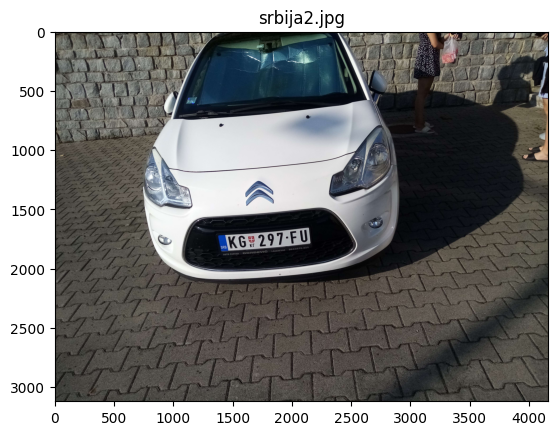


0: 480x640 1 License_Plate, 71.6ms
Speed: 7.2ms preprocess, 71.6ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 640)


-------------------------------------------------------


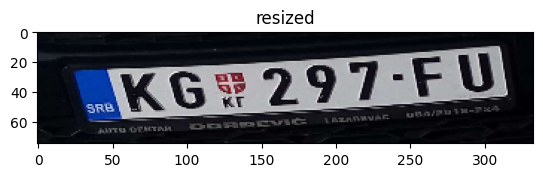

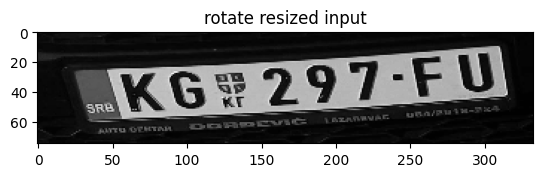

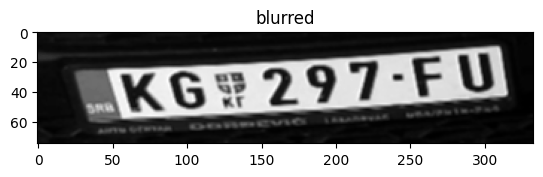

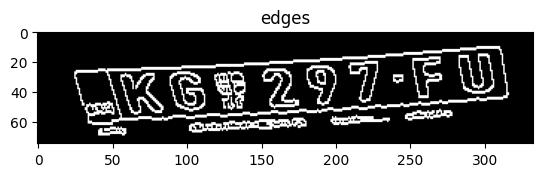

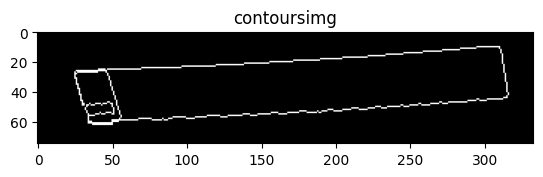

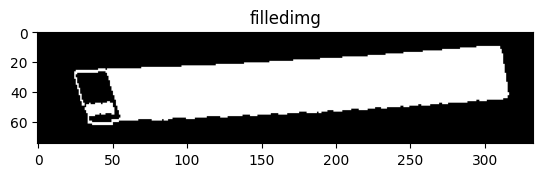

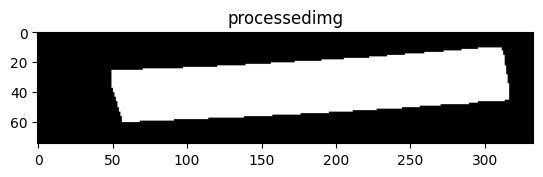

[(50, 26), (311, 11), (57, 60), (316, 45)]


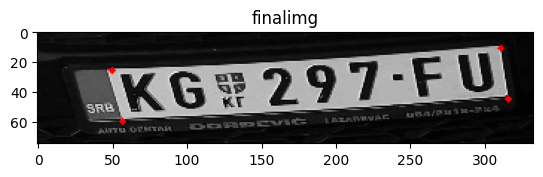

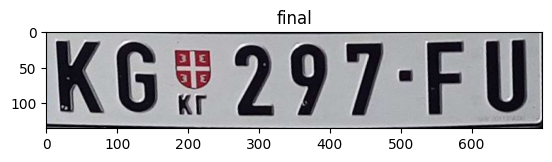

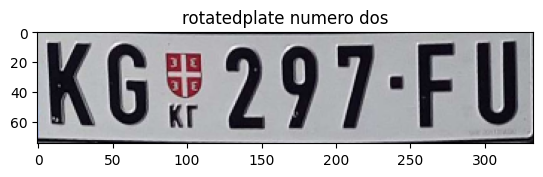

dims
[12, 33, 65, 95]
[12, 33, 38, 48]


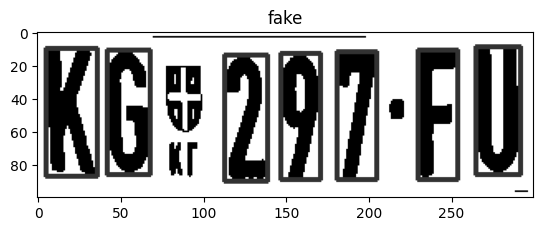

1/1 [==============================] - 0s 21ms/step
result (7 characters): K6297FU
-------------------------------------------------------


In [122]:
img = input(f"{root}/test-images/srbija2.jpg")
plates = crop_plates(img)
print("-------------------------------------------------------")
for plate in plates:
  rotated = None
  try:
    rotated = rotate_plate(plate)
    # show(rotated, "rotatedplate")
  except:
    print("couldnt rotate plate")
    rotated = plate

  rotated = cv2.resize(rotated, (333, 75))
  show(rotated, "rotatedplate numero dos")

  try:
    char = segment_characters(rotated)
    n = len(char)
    reg = show_results(char)

    # for i, c in enumerate(char):
    #   show(c, f"{reg[i]}")

    print(f"result ({n} characters): {reg}")
    print("-------------------------------------------------------")
  except Exception as e:
    print("couldnt segment characters")
    print(e)